# Table Of Contributions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

d = {'Student Name' : ['Bogdan Capsa, Maria Kalimantzali Liana', 'Bogdan Capsa, Maria Kalimantzali Liana'], 
     'Student Number(Contribution)' : ['s210172(40%), s176449(60%)', 's210172(60%), s176449(40%)']
     } 
  
ct = pd.DataFrame(d, index = ['Imputation', 'AR2']) 

ct


,Student Name,Student Number(Contribution)
Imputation,"Bogdan Capsa, Maria Kalimantzali Liana","s210172(40%), s176449(60%)"
AR2,"Bogdan Capsa, Maria Kalimantzali Liana","s210172(60%), s176449(40%)"


# Introduction

In this notebook, we will try to detect breakthrough (high permeate values)
through the analysis of historical permeate values. Essentially we are dealing with a time-series dataset, so we will be predicting when anomalies happen and what the future values will be. For this purpose, we will be using an AR2 model, turning the problem at hand into a temporal model.


# Imports

In [ ]:
!pip install numpyro
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
import pyro 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import scipy

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# Discovering the missing values

The data consists of a time series, with permeate values recorded for different days. Almost 50% of the data is missing, so we'll also have to do some imputations. We'll compare the bayesian imputation results with Python's in-built interpolation.

## Bayesian Imputation

In [ ]:
df_orig = pd.read_csv("https://raw.githubusercontent.com/PriceTT/DSND-Capstone/master/permeate_data.csv")
df_orig.rename(columns={'sample_created_date': 'date'},inplace=True, errors='raise')
df_orig['date'] = pd.to_datetime(df_orig['date'], errors='coerce', infer_datetime_format=True).dt.date
df_orig = df_orig.groupby(['date'], axis=0, as_index=False).mean()
df_orig

,date,mean_value_scaled
0,2009-07-08,0.000739
1,2009-07-14,0.001776
2,2009-07-15,0.002695
3,2009-07-16,0.079203
4,2009-07-17,0.003977
...,...,...
1436,2019-09-09,0.007125
1437,2019-09-13,0.000000
1438,2019-09-19,0.011659
1439,2019-09-20,0.003309


We observe that the timeseries do not have measurements for every day. Additionally there are days that have more than 1 measurements. Thus for these days with multiple measurements we take the mean of them. However, for the timeseries we need to have consequeative dates. We observe that the starting date is "2009-07-08" while the last date of the measurements is "2019-10-02". Thus we assume that the missing values is approximately 50%. For this reason we would like to perform imputation for the missing values.

In [ ]:
df_imputed = pd.read_csv("https://raw.githubusercontent.com/PriceTT/DSND-Capstone/master/permeate_data.csv")
df_imputed.rename(columns={'sample_created_date': 'date'},inplace=True, errors='raise')
df_imputed = df_imputed.groupby(['date'], axis=0, as_index=False).mean()

df_imputed['date'] = pd.to_datetime(df_imputed['date'], errors='coerce', infer_datetime_format=True).dt.date
min_date = df_imputed.date.min()
max_date = df_imputed.date.max()
print("min_date", min_date)
print("max_date", max_date)

df_imputed.set_index("date",inplace=True)

dtr = pd.date_range(min_date, max_date, freq='D')
s = pd.Series(index=dtr)
df_imputed = pd.concat([df_imputed, s[~s.index.isin(df_imputed.index)]]).sort_index()
df_imputed = df_imputed.drop([0],axis=1)
df_imputed['original'] = np.where(df_imputed['mean_value_scaled'].notnull(), 'yes', 'no')
df_imputed = df_imputed.reset_index().rename(columns={'index':'date'})
df_imputed

min_date 2009-07-08
max_date 2019-10-02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
/usr/local/lib/python3.7/dist-packages/pandas/core/sorting.py:403: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


,date,mean_value_scaled,original
0,2009-07-08,0.000739,yes
1,2009-07-09,NaN,no
2,2009-07-10,NaN,no
3,2009-07-11,NaN,no
4,2009-07-12,NaN,no
...,...,...,...
3734,2019-09-28,NaN,no
3735,2019-09-29,NaN,no
3736,2019-09-30,NaN,no
3737,2019-10-01,NaN,no


 The obstacle we have to face is that when we perform imputation we should calculate the errors regarding the data that we already have.  Thus, we chose to remove 20% of the data that we originally have in order to test the performance of the imputation.

In [ ]:
N= df_imputed.shape[0]
perm1 = np.random.permutation(N)
print("len(perm1)", len(perm1))

missing_perc = 0.2
ix_mis1 = perm1[:int(missing_perc * N)]
print("len(ix_mis1)", len(ix_mis1))
# ix_mis1
perm1

len(perm1) 3739
len(ix_mis1) 747


array([1151,  538,  351, ...,  860, 3507, 3174])

In [ ]:
# drop 20% of the orig values
#  total num of consecutive dates
N = len(df_orig)
y = df_imputed['mean_value_scaled'].values
df_orig['original'] = 'yes'
# df_imputed['original'] = np.where(df_imputed['mean_value_scaled'].notnull(), 'yes', 'no')
missing_perc = 0.2 # missing percentage

# get idxes that had original values
perm_idx_orig = df_imputed[df_imputed['original']=='yes'].index.values

ix_mis = perm_idx_orig[:int(missing_perc * N)] # missing indexes
ix_obs = perm_idx_orig[int(missing_perc * N):] # observed indexes
y_mis = y[ix_mis] 
y_obs = y[ix_obs] 

## Modelling Imputation

The imputation will be represented by an auto-regressive model of order 1.

In [ ]:
def ar1(carry, noise_t):
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

For the model of imputation we use an AR1 model. We have chosen the values of the coefficient $beta$ to follow a Normal distribution. We need the coefficients tau and sigma to follow a Halfcauchy distribution because we need them to have strictly positive values. Additionally, in the begining we used Beta distribution fro the values of z_prev in order to restrict the parameter to have values in the range(0,1) and most of them to be closer to 0. However the performance was worse thatn using a Normal distribution. Thus we conclueded on the followin model.

In [ ]:
def model_interpolation(T, T_forecast, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over beta, tau, noises, sigma, z_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=0., scale=1))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
    noises = numpyro.sample("noises", fn=dist.Normal(0, 1), sample_shape=(T+T_forecast-1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Beta(1, 3))

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(ar1, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed y (y_obs) and missing y (y_mis)
    numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    return z_collection

In [ ]:
# Run inference - MCMC:

t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_interpolation)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N, T_forecast=0, obs=y, ix_mis=ix_mis, ix_obs=ix_obs)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [02:34<00:00, 12.97it/s, 1023 steps of size 1.04e-04. acc. prob=0.78]


Total time: 2.641m


In [ ]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        beta      0.85      0.03      0.86      0.81      0.90      3.20      1.95
   noises[0]      1.19      0.02      1.19      1.15      1.23      9.14      1.07
   noises[1]     -0.01      0.17      0.03     -0.36      0.20      3.82      1.66
   noises[2]     -1.66      0.04     -1.65     -1.74     -1.59      4.81      1.60
   noises[3]     -0.01      0.21      0.04     -0.43      0.27      6.26      1.48
   noises[4]     -1.25      0.25     -1.21     -1.60     -0.85      3.71      1.65
   noises[5]     -0.46      0.38     -0.35     -1.03      0.06      3.24      1.63
   noises[6]     -0.53      0.07     -0.54     -0.63     -0.41      7.69      1.44
   noises[7]      0.82      0.07      0.83      0.71      0.93      5.64      1.06
   noises[8]     -0.21      0.09     -0.23     -0.35     -0.07      5.90      1.47
   noises[9]     -0.43      0.13     -0.44     -0.61     -0.21      5.38      1.73
  n

### Extract samples and plot posteriors over some of the latent variables (parameters): beta, tau and sigma

We observe that the inferance performs well since the output parameters n_eff  r_hat have reasonable values ie the r_hat is more than 1 and approximately 1.05 while n_eff is not the best but at least it has kind of high values

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


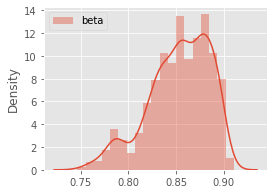

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


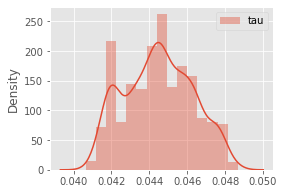

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


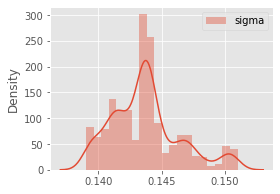

In [ ]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
import copy
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_hat_copy = copy.deepcopy(y_hat)
y_hat_copy = np.exp(y_hat_copy) - 0.75
y_std = hmc_samples["y_mis"].std(axis=0)

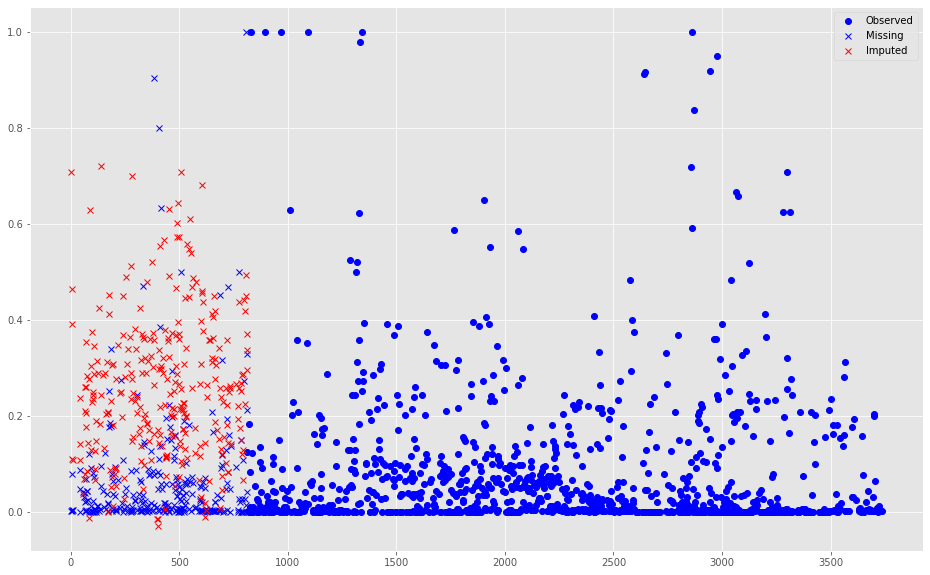

In [ ]:
plt.plot(ix_obs, y_obs, "bo")
plt.plot(ix_mis, y_mis, "bx")
plt.plot(ix_mis, y_hat_copy, "rx")
plt.legend(["Observed", "Missing", "Imputed"]);

One can notice that a few values are below 0. However, after multiple hyper parameters optimization within our choises for the distributions and their parameters, we have decided to keep the current model. We believe that the negative values can come from the noises(sigma), which follows normal distribution and in combination with plenty of previous 0 values, can lead to negative values within the imputed values.

Furthermore, we'll create a function for computing some statistical measurements for the performance of our model.  We'll be mainly interested in RMSE and MA. 

So, let us compute error statistics of the model's imputations:

In [ ]:
def compute_error(trues, predicted, title):
    # pearson = np.corrcoef(predicted, trues)[0,1]
    # spearman, _ = scipy.stats.spearmanr(trues, predicted)
    mae = np.mean(np.abs(predicted - trues))
    # rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    # r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))

    print(f"{title}")
    # print(f" PearsonCorr: {pearson}\n SpearmanCorr:{spearman}\n MAE:{mae}\n RAE:{rae}\n RMSE:{rmse}\n R2:{r2}")
    print(f" MAE:{mae}\n RMSE:{rmse}")

In [ ]:
compute_error(y_mis, y_hat, "Imputation results")

Imputation results
 MAE:0.1534595787525177
 RMSE:0.2069513350725174


We also wanted to compare the imputation with the interpolation. We have considered the imnterpolation as a basiline, Thus we want to compare the imputed values with the baseline (interpolation) in order to decide which model performs better

In [ ]:
df_interpolate = pd.read_csv("https://raw.githubusercontent.com/PriceTT/DSND-Capstone/master/permeate_data.csv")
df_interpolate.rename(columns={'sample_created_date': 'date'},inplace=True, errors='raise')
df_interpolate = df_interpolate.groupby(['date'], axis=0, as_index=False).mean()

df_interpolate['original'] = np.where(df_interpolate['mean_value_scaled'].notnull(), 'yes', 'no')
df_interpolate['date'] = pd.to_datetime(df_interpolate['date'], errors='coerce', infer_datetime_format=True).dt.date
min_date = df_interpolate.date.min()
max_date = df_interpolate.date.max()
print("min_date", min_date)
print("max_date", max_date)

df_interpolate.set_index("date",inplace=True)

dtr = pd.date_range(min_date, max_date, freq='D')
s = pd.Series(index=dtr)
df_interpolate = pd.concat([df_interpolate, s[~s.index.isin(df_interpolate.index)]]).sort_index()
df_interpolate = df_interpolate.drop([0],axis=1)
df_interpolate = df_interpolate.interpolate()

min_date 2009-07-08
max_date 2019-10-02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
/usr/local/lib/python3.7/dist-packages/pandas/core/sorting.py:403: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]

In [ ]:
df_interpolate.reset_index(inplace = True)
df_interpolate.rename(columns={'index':'date'}, inplace = True)
df_interpolate['date'] = pd.to_datetime(df_interpolate['date'], errors='coerce', infer_datetime_format=True).dt.date
df_interpolate

,date,mean_value_scaled,original
0,2009-07-08,0.000739,yes
1,2009-07-09,0.000912,NaN
2,2009-07-10,0.001085,NaN
3,2009-07-11,0.001257,NaN
4,2009-07-12,0.001430,NaN
...,...,...,...
3734,2019-09-28,0.001712,NaN
3735,2019-09-29,0.001512,NaN
3736,2019-09-30,0.001313,NaN
3737,2019-10-01,0.001113,NaN


In order to compare failry the 2 models (interpolation and imputation ) we chose to drop 20% of the original data and consider those values as missing. Thus, we use these values as our test set in order to compute the error of the interpolated data. We made this process in order to compare imputation and interpolation regarding the same 20% of test missing data.

In [ ]:
# drop 20% of the orig values
#  total num of consecutive dates
N = len(df_orig)
y = df_interpolate['mean_value_scaled'].values
df_orig['original'] = 'yes'
df_interpolate['original'] = np.where(df_interpolate['mean_value_scaled'].notnull(), 'yes', 'no')
missing_perc = 0.2 # missing percentage

# get idxes that had original values
perm_idx_orig = df_interpolate[df_interpolate['original']=='yes'].index.values

ix_mis = perm_idx_orig[:int(missing_perc * N)] # missing indexes
ix_obs = perm_idx_orig[int(missing_perc * N):] # observed indexes
y_mis = y[ix_mis] 
y_obs = y[ix_obs] 

In [ ]:
df_orig['date'] = df_orig.index.map(dict(zip(df_interpolate.index,df_interpolate['date'])))

In [ ]:
trues = []
for i in range(len(ix_mis)):
  trues.append(df_orig.loc[ix_mis[i]]['mean_value_scaled'])
  #print( df_orig.loc[ix_mis[i]]['mean_value_scaled'] )
#len(trues)

In [ ]:
df_interpolate.drop(ix_mis)
y_hat = df_interpolate.interpolate()
y_hat.shape


(3739, 3)

In [ ]:
y_hat = y_hat.loc[ix_mis]['mean_value_scaled'].values
print(y_hat, len(y_hat))

[7.38953728e-04 9.11752832e-04 1.08455194e-03 1.25735104e-03
 1.43015014e-03 1.60294925e-03 1.77574835e-03 2.69500772e-03
 7.92025862e-02 3.97730977e-03 6.60168304e-03 9.22605631e-03
 1.18504296e-02 1.44748029e-02 1.70991761e-02 1.97235494e-02
 2.23479227e-02 2.49722959e-02 2.75966692e-02 3.02210425e-02
 3.28454157e-02 3.54697890e-02 3.80941623e-02 4.07185356e-02
 4.33429088e-02 4.59672821e-02 4.85916554e-02 5.12160286e-02
 5.38404019e-02 5.64647752e-02 5.90891484e-02 6.17135217e-02
 6.43378950e-02 6.69622683e-02 6.95866415e-02 7.22110148e-02
 7.48353881e-02 7.74597613e-02 8.00841346e-02 8.27085079e-02
 8.53328811e-02 8.79572544e-02 6.76899674e-02 4.74226804e-02
 0.00000000e+00 3.34976615e-03 6.69953230e-03 1.00492984e-02
 1.33990646e-02 1.67488307e-02 2.00985969e-02 2.34483630e-02
 2.67981292e-02 3.01478953e-02 3.34976615e-02 3.68474276e-02
 4.01971938e-02 3.79839920e-02 3.57707902e-02 3.35575885e-02
 3.13443867e-02 3.30835649e-02 3.48227432e-02 3.65619215e-02
 3.83010997e-02 2.936064

In [ ]:
# corr, mae, rae, rmse, r2 = compute_error(trues, y_hat)
# print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))
compute_error(trues, y_hat, "Interpolation results")

Interpolation results
 MAE:0.07735044738464864
 RMSE:0.14568303258266257


The interpolation performs better than the imputation based on the MAE and RMSE (interpolation has lower error rates than the imputation). This could be due to the fact that if we had more mearurements that are correlated to the "mean_value_scaled" then the imputation would have performed better because it would have used this correlation between the measurements and it would have imputed better the missing values (like the notebook with the multiple sensors that had an outstanding performance even when we had 80% missing values). However in our case the baseline (interpolation) has better performance than the more complex models (imputation)

## Python Interpolation

For diversity reason, we'll now try to discover the missing values, using Python's in-buil interpolation. For that purpose, we will replace all the missing values with values obtained from Python's in-built interpolation. This should offer a farely good result in getting the missing data.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/PriceTT/DSND-Capstone/master/permeate_data.csv")
df.rename(columns={'sample_created_date': 'date'},inplace=True, errors='raise')
df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True).dt.date
df = df.groupby(['date'], axis=0, as_index=False).mean()
df.head()

,date,mean_value_scaled
0,2009-07-08,0.000739
1,2009-07-14,0.001776
2,2009-07-15,0.002695
3,2009-07-16,0.079203
4,2009-07-17,0.003977


In [ ]:
min_date = df.date.min()
max_date = df.date.max()
print("min_date", min_date)
print("max_date", max_date)

df.set_index("date",inplace=True)

dtr = pd.date_range(min_date, max_date, freq='D')
s = pd.Series(index=dtr)
df_interpolate = pd.concat([df, s[~s.index.isin(df.index)]]).sort_index()
df_interpolate = df_interpolate.drop([0],axis=1)
df_interpolate = df_interpolate.interpolate()

min_date 2009-07-08
max_date 2019-10-02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
/usr/local/lib/python3.7/dist-packages/pandas/core/sorting.py:403: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


In [ ]:
from IPython.display import Markdown as md
num_obs = df_interpolate.shape[0]
md(f"The data consists of {num_obs} observations. \
  Furthermore, we'll create a function for computing some statistical measurements for the peroformance of our model. \
  We'll be mainly interested in RMSE and MA")

The data consists of 3739 observations.   Furthermore, we'll create a function for computing some statistical measurements for the peroformance of our model.   We'll be mainly interested in RMSE and MA

# AutoRegressive2 Model

We will try to solve the problem at hand with an auto regressive model of order 2, finding the right distributions for all variables involved. 

In [ ]:
# convert data to a matrix
y = df_interpolate.values
N, D = y.shape
print("N=%d, D=%d" % (N,D))

idx_train = range(2599, 3719)
idx_test = range(3719, 3739)

N_train = len(idx_train)
N_test = len(idx_test)
print("N_train:", N_train)
print("N_test:", N_test)
y_train = y[idx_train,:]
y_test = y[idx_test,:]

N=3739, D=1
N_train: 1120
N_test: 20


Below one can take a look at how the plain auto-regressive looks like. We'll first exclude the and consider only point estimates.

In [ ]:
def ar_pure(carry, x=None):
  beta1, beta2, z_prev1, z_prev2 = carry
  z_feature = beta1*z_prev1 + beta2*z_prev2
  z_prev1 = z_prev2
  z_prev2 = z_feature
  return (beta1, beta2, z_prev1, z_prev2), z_feature

Now we shall test its functionality, plugging in some values which are easily tractable.

For the slopes, we'll take 1, whereas for z_prev1 and z_prev2 we'll take 2 and 2.5

z_t will represent the final result and should be 4.5

In [ ]:
beta1 = beta2 = 1.
z_prev1 = 2.
z_prev2 = 2.5
prev_values = (beta1, beta2, z_prev1, z_prev2)
prev_values_updated, z_t = ar_pure(prev_values) # propagating the dynamics forward for 1 time step
print(f"Initial carried items: \nbeta1: {prev_values[0]}, beta2: {prev_values[1]}, z_prev1: {prev_values[2]}, z_prev2: {prev_values[3]}")
print(f"Updated carried items: \nbeta1: {prev_values_updated[0]}, beta2: {prev_values_updated[1]}, z_prev1: {prev_values_updated[2]}, z_prev2: {prev_values_updated[3]}")
print(f"Computed z_t: {z_t}")

Initial carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 2.0, z_prev2: 2.5
Updated carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 2.5, z_prev2: 4.5
Computed z_t: 4.5


The result seems correct, so now we should  add also some noise to the function.

It's important to note that $\boldsymbol\sigma$ will represent a vector of noises, for all the observed and predicted temporal values

In [ ]:
def ar2(carry, noise):
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise
    z_prev1 = z_prev2
    z_prev2 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

In [ ]:
beta1 = beta2 = 1.
z_prev1 = 2.
z_prev2 = 2.5
tau = 1.
prev_values = (beta1, beta2, z_prev1, z_prev2, tau)
prev_values_updated, z_t = ar2(prev_values, noise=0.1) # propagating the dynamics forward for 1 time step
print(f"Initial carried items: \nbeta1: {prev_values[0]}, beta2: {prev_values[1]}, z_prev1: {prev_values[2]}, z_prev2: {prev_values[3]}")
print(f"Updated carried items: \nbeta1: {prev_values_updated[0]}, beta2: {prev_values_updated[1]}, z_prev1: {prev_values_updated[2]}, z_prev2: {prev_values_updated[3]}")
print(f"Computed z_t: {z_t}")

Initial carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 2.0, z_prev2: 2.5
Updated carried items: 
beta1: 1.0, beta2: 1.0, z_prev1: 2.5, z_prev2: 4.6
Computed z_t: 4.6


First of all, we need to pass to the Pyro model an array corresponding to the number of observations in our time series. Furthermore, we will also be passing a variable called **num_steps_ahead**, corresponding to the number of time-steps ahead of **num_obs** that need to be predicted.

Since our intention is to use bayesian models, we need to assign priors to $\boldsymbol\beta$, $\sigma$ and $\tau$, as we'll deal with distributions instead of point estimates. We will also assign priors on the first 2 latent states $x_1$ and $x_2$, as we are dealing with an AR2 model at hand, so since the regression is done on the value of the variable itself, the previous stream of values need to follow the same distribution as the target.Furthermore, $xcollection$ will represent the collection of the 2 previous values.

Below one can find the code implemented for our model. Here we will make the following assumptions:
*  The transition coefficients $\boldsymbol\beta$1 and $\boldsymbol\beta$1 ~ $\mathcal{N}(0, 1)$, following the normal distribution

*   $\boldsymbol\tau$ and $\boldsymbol\sigma$ follow Half-Cauchy distributions, as we want them to reach positive values strictly: we need positive values for the noise, in order to make sure that we will not get any negative permeate values

*   $Xprev1$ and $Xprev2$ will follow a Normal distribution with mean of 0 and sigma of 0.3, as we consider there is not a lot of variation in the values taken by the permeate. The values variate between 0 and 1, so we have used a Beta distribution. 

In [ ]:
def ar2_model(n_obs, n_ahead, obs=None):
    # Define priors over beta1, beta2, tau, noises, sigma, x_prev1 and x_prev2
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0.3, scale=0.7))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0.3, scale=0.7))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 0.6), sample_shape=(n_obs+n_ahead-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    # old
    # x_prev1 = numpyro.sample(name="x_1", fn=dist.Normal(0., 0.3))
    # x_prev2 = numpyro.sample(name="x_2", fn=dist.Normal(0., 0.3))
    x_prev1 = numpyro.sample(name="x_1", fn=dist.Beta(2., 5.))
    x_prev2 = numpyro.sample(name="x_2", fn=dist.Normal(2., 5.))
    # end old
    """Propagate the dynamics forward using jax.lax.scan"""
    carry = (beta1, beta2, x_prev1, x_prev2, tau)
    x_collection = [x_prev1, x_prev2]
    carry, zs_exp = lax.scan(ar2, carry, noises, n_obs+n_ahead-2)
    x_collection = jnp.concatenate((jnp.array(x_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) """
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=x_collection[:n_obs], scale=sigma), obs=obs[:n_obs])

    numpyro.sample(name="y_pred", fn=dist.Normal(loc=x_collection[n_obs:], scale=sigma), obs=None)
    return x_collection

Nowe, using the model, we shall sample both observed and predicted y, as we will use 'y_pred' later on in the MCMC approximate infference.

So let's run inference, using MCMC

In [ ]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=ar2_model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, n_obs=N_train, n_ahead=N_test, obs=y_train[:,0])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [01:32<00:00, 43.40it/s, 255 steps of size 5.00e-03. acc. prob=0.94]


Total time: 1.666m


In [ ]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_1     -0.11      0.04     -0.11     -0.16     -0.05    106.11      1.06
      beta_2      0.83      0.04      0.82      0.76      0.89     28.56      1.13
   noises[0]      0.12      0.19      0.12     -0.18      0.43   2111.51      1.00
   noises[1]      0.06      0.17      0.06     -0.22      0.35    929.78      1.00
   noises[2]     -0.01      0.17     -0.00     -0.33      0.23    419.06      1.00
   noises[3]     -0.07      0.18     -0.08     -0.38      0.22    381.14      1.00
   noises[4]     -0.14      0.18     -0.14     -0.43      0.17    936.02      1.00
   noises[5]      0.03      0.18      0.03     -0.29      0.30   1594.19      1.00
   noises[6]     -0.00      0.18     -0.00     -0.30      0.29   1361.95      1.00
   noises[7]      0.01      0.18      0.00     -0.29      0.30    862.10      1.00
   noises[8]     -0.00      0.18     -0.00     -0.32      0.28    845.30      1.00
   

Values for *r_hat* are very close to 1, showing us that the chains have mixed quiet well. *r_hat*  is an indicator for the R-hat convergence diagnostic compares in fact the between- and within-chain estimates for the model parameters and other univariate quantities of interest.

Furthermore, n_eff values are also quiet high, showing that the inference is doing a good job.

Next we'll plot the values for the parameters beta1, beta2, tau and sigma.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


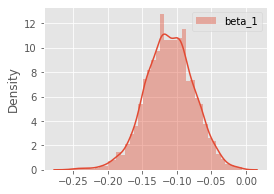

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


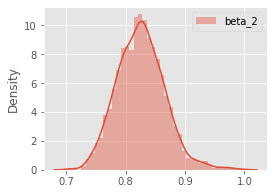

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


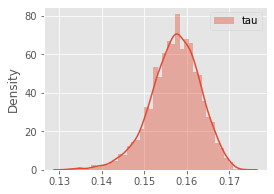

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


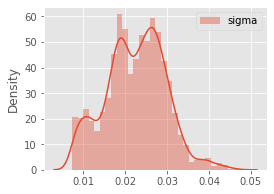

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["beta_1", "beta_2", "tau", "sigma"]
for node in nodes:
  plt.figure(figsize=(4,3))
  sns.distplot(hmc_samples[node], label=node)
  plt.legend()
  plt.show()

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
hmc_samples

{'beta_1': DeviceArray([-0.23217705, -0.20970401, -0.2219902 , ..., -0.14150986,
              -0.1314888 , -0.09821752], dtype=float32),
 'beta_2': DeviceArray([0.99380887, 0.97184336, 0.98002845, ..., 0.8679125 ,
              0.8612074 , 0.8379902 ], dtype=float32),
 'noises': DeviceArray([[ 0.60590667, -0.30180475, -0.37062043, ...,  0.18128385,
               -0.02325248, -0.8678277 ],
              [ 0.589991  , -0.42387405, -0.45422116, ...,  0.12532815,
                0.25993314, -0.38359252],
              [ 0.21899119, -0.46715748, -0.25794438, ..., -0.00151635,
                0.13399732, -0.4456266 ],
              ...,
              [-0.13225563,  0.17626455,  0.04798505, ...,  0.13419856,
               -0.09640368,  0.31154996],
              [ 0.39528936, -0.18698873,  0.15188456, ..., -0.2943963 ,
                0.1819184 ,  0.06672176],
              [-0.19039363,  0.10188522,  0.20259981, ..., -0.27897316,
                0.45181444,  0.16479215]], dtype=float32),


## Results Evaluation

In [ ]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

Now let's ty to plot our results, including some of the train points. We'll plot this agains some confidence intervals, namely the mean +- 1.96 x standard deviation of the predicted values.

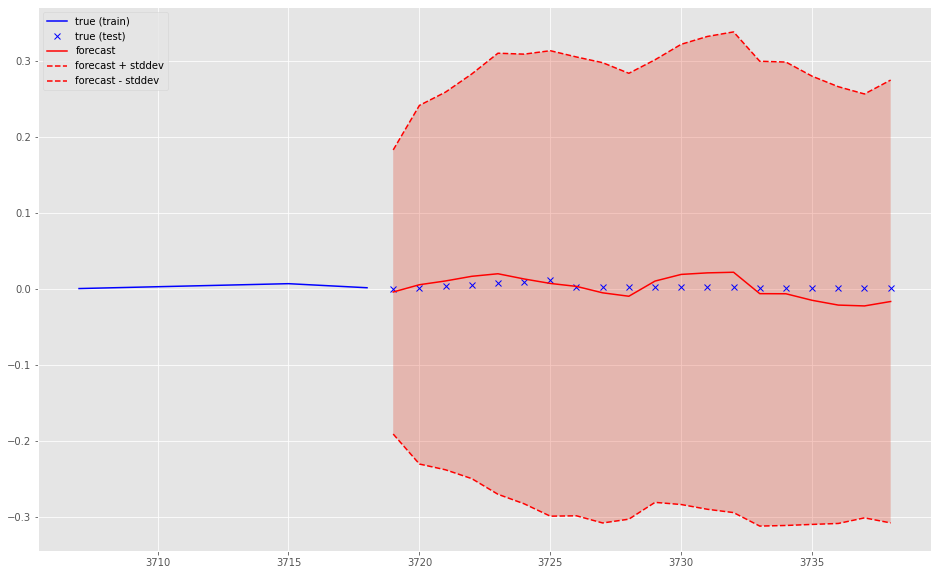

In [ ]:
plt.plot(idx_train[-12:], y_train[-12:], "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_pred_mean, "r-")
plt.plot(idx_test, y_pred_025, "r--")
plt.plot(idx_test, y_pred_975, "r--")
plt.fill_between(idx_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

As we can see, the model behaves relatively well, following quiet closely the true values. We also need to mention that there are plenty of 0 values in our data, as it is not really common to meet breakthroughs. Nevertheless, let us also analyse the coeficients, describing the model's error.

In [ ]:
compute_error(y_pred_mean, y_test.flatten(), "AR2 Test Results")

AR2 Test Results
 MAE:0.011231066659092903
 RMSE:0.013084008358418941


It seems that indeed the model performs quiet well, as the MAe and RMSE values seem relatively low (1.1%, and 1.3% respectively)

The notebook https://github.com/PriceTT/DSND-Capstone/blob/master/5-DSND-Capstone.ipynb a threshold for the breakthrough of **0.000553438873156040**, using VAE techniques on artificial created features. We will be using this threshold in the evaluation of our results.

In [ ]:
df_interpolate.reset_index()

,index,mean_value_scaled
0,2009-07-08,0.000739
1,2009-07-09,0.000912
2,2009-07-10,0.001085
3,2009-07-11,0.001257
4,2009-07-12,0.001430
...,...,...
3734,2019-09-28,0.001712
3735,2019-09-29,0.001512
3736,2019-09-30,0.001313
3737,2019-10-01,0.001113


In [ ]:
df_test_dates = df_interpolate.iloc[list(idx_test)].reset_index()
df_test_dates.rename(columns={'index': 'date', 'mean_value_scaled': 'y_test'}, inplace=True, errors='raise')
df_test_dates

,date,y_test
0,2019-09-13,0.000000
1,2019-09-14,0.001943
2,2019-09-15,0.003886
3,2019-09-16,0.005829
4,2019-09-17,0.007773
5,2019-09-18,0.009716
6,2019-09-19,0.011659
7,2019-09-20,0.003309
8,2019-09-21,0.003109
9,2019-09-22,0.002909


In [ ]:
y_pred_arr= np.array(y_pred_mean).flatten()
y_test_arr= np.array(y_test).flatten()

y_pred_series = pd.Series(y_pred_arr)
y_test_series = pd.Series(y_test_arr)
df_forecasted = pd.DataFrame({'y_pred': y_pred_series, 'y_test': y_test_series})

t_max = 0.0005534388731560402

df_forecasted['anomaly_real'] = np.where(df_forecasted['y_test'] > t_max, 'yes', 'no')
df_forecasted['anomaly_predicted'] = np.where(df_forecasted['y_pred'] > t_max, 'yes', 'no')

df_forecasted.merge(df_test_dates)

,y_pred,y_test,anomaly_real,anomaly_predicted,date
0,-0.003812,0.000000,no,no,2019-09-13
1,0.005749,0.001943,yes,yes,2019-09-14
2,0.010712,0.003886,yes,yes,2019-09-15
3,0.016813,0.005829,yes,yes,2019-09-16
4,0.020169,0.007773,yes,yes,2019-09-17
5,0.013314,0.009716,yes,yes,2019-09-18
6,0.007436,0.011659,yes,yes,2019-09-19
7,0.003555,0.003309,yes,yes,2019-09-20
8,-0.004899,0.003109,yes,no,2019-09-21
9,-0.009387,0.002909,yes,no,2019-09-22


# Conclusions

This section concludes our work on the Bayesian Data Set. We have imputed missing values, comparing those with Python's in-built interpolation. Then, we have used AR2 modelling techniques to detect permeate breakthough. It brought relative good results, as both RMSE and MAE were close to 1%. However, after a more detailed analysis, it seems, like the model is inclined to lead, up to some degree, to false negatives, leaving space for future improvements, such as different kinds of models, like Gaussian Processes.

Nevertheless, the AR represents a good overall approach, and we believe it would be of great interest to use it on larger amounts of data, with less missing values.